# <center> *mocalum* tutorial 3 <br><br> Generation of 3D and 4D flow fields<center>

A notebook by Nikola Vasiljević
    
 ## Introduction
 This is an interactive tutorial that will introduce you how flow fields are generated in `mocalum`. For more details on `movalum` consult the previous tutorials. 
    

In [25]:
import numpy as np           
import matplotlib.pyplot as plt
import xarray as xr

import mocalum as mc

from mocalum_tutorial import plot_md_scan_setup, plot_bbox,plot_ffield

In [2]:
from mocalum_tutorial import bbox_pts_from_cfg

## Create and explore mocalum object

We start our tutorial by creating an instance of `mocalum` object:

In [3]:
mc_dual_Doppler = mc.Mocalum()

## Adding lidars and configuring uncertanty

Lets consider a dual-Doppler setup with two lidars, named `koshava` and `sterenn`, located at positions of (0,500,0) and (0,-500,0) respectevely with the same standard uncertainties:
- estimation uncertainty of radial velocity of 0.1 m/s 
- ranging uncertainty of 5 m
- azimuth uncertainty of 0.1 deg
- elevation uncertainty of 0.1 deg
We will consider that uncertainty values are not correlated between two lidars.

To add these two lidars we simply execute `add_lidar` method twice in row:

In [4]:
koshava_xyz = np.array([500,500,0])
sterenn_xyz = np.array([500,-500,0])


unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':0}

mc_dual_Doppler.add_lidar('koshava', koshava_xyz, unc_cfg)
mc_dual_Doppler.add_lidar('sterenn', sterenn_xyz, unc_cfg)

The lidar information are added to the measurement configuration dictionary stored inside `data` subobject:

In [5]:
mc_dual_Doppler.data.meas_cfg['koshava']

{'position': array([500, 500,   0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {}}

In [6]:
mc_dual_Doppler.data.meas_cfg['sterenn']

{'position': array([ 500, -500,    0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {}}

## Setting up measurement scenario for previously added lidar

Following the lidar placement and uncertainty configuration we will configure the measurement scenario which the two lidars will 'virtually' perform. In this example that will be an arbitrary trajectory containing a number of measurement points on a horizontal line located at 100 m above ground level. To add this trajectory we will use the built-in method `generate_complex_trajectory`, which requires following inputs:
 - lidar ids provided as a list of strings for which the complex trajectory will be generated
 - Scan configuration as a dictionary containing following required parameter:
    - `points` : numpy array of measurement points provided as triplets of coordinates (x, y, z)
    
   while following parameters are optional: 
    - `no_scans` : number of scans through the points, by default set to 1   
    - `acq_time` : acquisition time of LOS measurements, by default 1 (s)
    - `max_speed` : max permitted angular speed, by default 50 (deg/s)
    - `max_acc` : max permitted angular acceleration, by default 100 (deg/s^2)
    - `sync` : indicates whether to synchronize (set to True) or not (set to False) motion among multiple lidars
    

In [7]:
pts_x = np.arange(0, 1100, 100)

pts = np.array([pts_x, np.full(len(pts_x), 0), np.full(len(pts_x), 100)]).T

CT_cfg = {
    'points': pts,
    'no_scans' : 1,
    'acq_time' :1,
    'sync':True,
    'max_speed' : 50,    # degree.s^-1
    'max_acc' : 100     # degree.s^-2
}

mc_dual_Doppler.generate_complex_trajectory(['koshava', 'sterenn'],CT_cfg)

In [8]:
mc_dual_Doppler.data.probing['koshava'].az

<xarray.DataArray 'az' (time: 11)>
array([225.        , 218.65980825, 210.96375653, 201.80140949,
       191.30993247, 180.        , 168.69006753, 158.19859051,
       149.03624347, 141.34019175, 135.        ])
Coordinates:
  * time     (time) float64 1.0 2.712 4.497 6.353 ... 14.09 15.94 17.73 19.44
Attributes:
    long_name:      Azimuth angle
    standard_name:  azimuth_angle
    units:          degree
    URI:

Lets depict the measurement setup. To do this we will use `plot_md_scan_setup`,  the same function we used in `tutorial 2`. This function will show the first out of in this case 10000 scans.

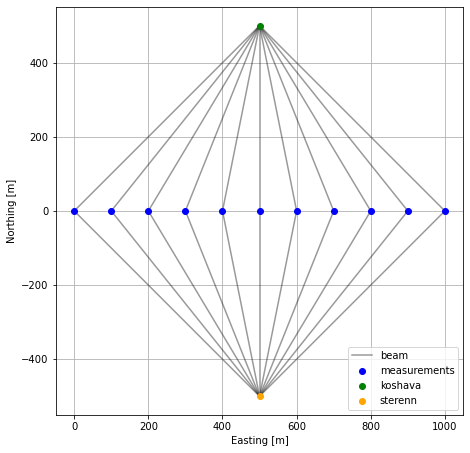

In [9]:
plot_md_scan_setup(['koshava', 'sterenn'], mc_dual_Doppler)

Next, we will sample uncertainties for the two lidars, yet again display measurement setup:

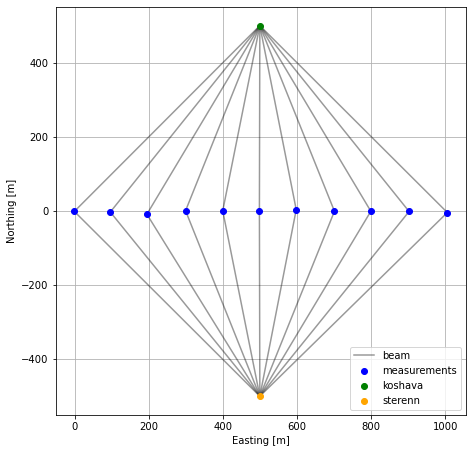

In [10]:
mc_dual_Doppler.generate_uncertainties('koshava')
mc_dual_Doppler.generate_uncertainties('sterenn')
plot_md_scan_setup(['koshava', 'sterenn'], mc_dual_Doppler)

As expected there is a slight deviation in measurement positions due to now introduced uncertainties contributors, especially the laser beam pointing uncertainty. As we sample and inject the uncertainties into the probing datasets the actual volume within which the probing takes place will enlarge. The information about bounding box around the measurement points is saved as a python `dictionary`. As such it represents a conviniet way of fetching the information about the dimensions to generate the flow field by internal `mocalum` method. Here is an example of bounding box dict for `koshava` which is accessible via `.data.bbox_meas_pts[lidar_id]`:

In [11]:
mc_dual_Doppler.data.bbox_meas_pts['koshava']

{'CRS': {'x': 'Absolute coordinate, coresponds to Easting in m',
  'y': 'Absolute coordinate, coresponds to Northing in m',
  'z': 'Absolute coordinate, coresponds to height above sea level in m',
  'rot_matrix': array([[ 1.,  0.],
         [-0.,  1.]])},
 'x': {'min': -25.443789812505827,
  'max': 1030.8612783334272,
  'offset': 0,
  'res': 25},
 'y': {'min': -33.850484493812075,
  'max': 28.50017116672018,
  'offset': 0,
  'res': 25},
 'z': {'min': 93.80537447825473,
  'max': 107.69587876005815,
  'offset': 0,
  'res': 5},
 't': {'min': 1.0,
  'max': 19.440686000013702,
  'offset': 0,
  'res': 1.8440686000013702}}

When the method `generate_flow_field` is executed it takes bounding box information, in this case for two lidars, and creates the appropriate size of 3D or 4D data structure, runs the flow model, and populates the data structure with wind vector information. Let's start with `uniform` flow field generation in which the flow only changes with height according to the [power law wind profile](https://en.wikipedia.org/wiki/Wind_profile_power_law). Even though the generated flow field dataset could contain only one dimensional coordinate (i.e, height above the ground level), for the purpose of keeping the `mocalum` backend more generic a 3D dataset is created.

In [12]:
atmo_cfg={'wind_speed':10,
          'upward_velocity':0,
          'wind_from_direction':45,
          'reference_height':100, # we set the reference height same as the scanned height 
          'shear_exponent':0.2}

mc_dual_Doppler.generate_flow_field(['koshava', 'sterenn'], atmo_cfg, 'uniform')

Let's visualize the extent of the flow field dataset in 2D to make sure that it does entail all the measurement points. To do this a convenience function `plot_bbox` was made (red arrow represents wind direction):

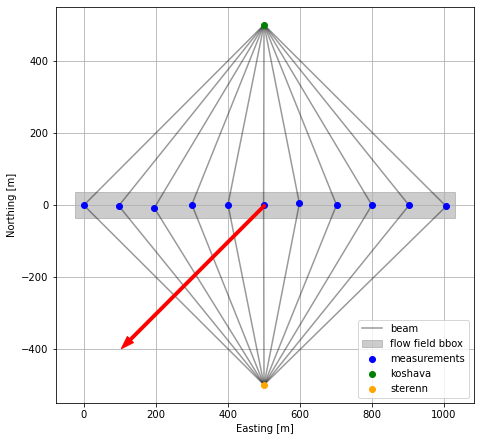

In [13]:
plot_bbox(mc_dual_Doppler)

Lets inspect the content of the flow field dataset. As shown in the cell below, the flow field dataset contains 3 data variables (u, v and w), 3 dimensional coordinates (x, y, z) and 3 non-dimensional coordinates (Easting, Northing and Height). x,y and z are indentical to Easting, Northing and Height since in case of `uniform` flow field generation the absolute coordiante system is used (i.e., the coordinate system in which the lidar position is supplied). Additional metadata about dimensions, coordinates and variables are accessible and usually contains `standard_name` which is represents standardized namings and units provided by [`cf`](http://cfconventions.org/Data/cf-standard-names/71/build/cf-standard-name-table.html#projection_x_coordinate) convention (Climate Forecast):

In [14]:
mc_dual_Doppler.data.ffield

<xarray.Dataset>
Dimensions:   (x: 44, y: 4, z: 4)
Coordinates:
  * x         (x) float64 -25.68 -0.6794 24.32 ... 999.3 1.024e+03 1.049e+03
  * y         (y) float64 -36.49 -11.49 13.51 38.51
  * z         (z) float64 92.78 97.78 102.8 107.8
    Easting   (x) float64 -25.68 -0.6794 24.32 ... 999.3 1.024e+03 1.049e+03
    Northing  (y) float64 -36.49 -11.49 13.51 38.51
    Height    (z) float64 92.78 97.78 102.8 107.8
Data variables:
    u         (z, y, x) float64 -6.966 -6.966 -6.966 ... -7.178 -7.178 -7.178
    v         (z, y, x) float64 -6.966 -6.966 -6.966 ... -7.178 -7.178 -7.178
    w         (z, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:      Flow field dataset
    generator:  power_law

Since we configured the flow fiend generator such to simulate the wind coming from the East, the values for `v` and `u` component should be identical, which can be quickly validated by substracting their values :

In [15]:
mc_dual_Doppler.data.ffield.v - mc_dual_Doppler.data.ffield.u

<xarray.DataArray (z: 4, y: 4, x: 44)>
array([[[-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16],
        [-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16],
        [-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16],
        [-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16]],

       [[-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16,
         -8.8

As mentioned in the previous tutorials `turbulent` flow fields are generated using `pyconturb`. By default, `pyconturb` can generate 3D turbulence box aligned with the mean wind direction, which coordinates are `time` , height and coordinate `y'` which is orthogonal to wind direction. Usually the lenght of the generated turbulence box is 600s ~ 10 min. Directly we cannot use the `pyconturb` turbulence box in `mocalum`, since it requires either 3D spatially structured flow field data or 4D (space and time). That's the reason why a wrapper, containing the data wrangler which restructures the `pyconturb` output, was made in mocalum. This wrapper converts `pyconturb` 3D turbulence box, which contains a mixture of spatial and time coordinates, first to 3D spatial datasets and then into 4D dataset. The conversion from 3D to 4D is done considering the *Taylor Frozen Turbulence Hypothesis*. Basically, we can view the `time` coordinate as an `x'` coordinate which is inline with the wind direction (see figure below).


<img align="center" src="assets/turb_start.png">

The time steps of 3D turbulence box are converted to `x'` coordinates considering the following expressions:

<img src="https://latex.codecogs.com/svg.latex?\Large&space; x'_{i}= V_{mean} * t_{i}" title="x coordinate" />
<img src="https://latex.codecogs.com/svg.latex?\Large&space; t_{i} = i*\Delta t, i=0,1,..,N" title="x coordinate" />

If we have long enough turbulence box we can perform a sliding window slicing, where the window size is sufficient to cover the measurement points, and convert 3D into 4D turbulence box:

<img align="center" src="assets/3D_to_4D.png">

This is exactly what `mocalum` is doing. Prequal to the data wrangling, `mocalum` considers the bounding boxes around the measurement points and efficiently configures `pyconturb` to generate the initial turbulence box.

Lets generate 4D `turbulent` flow field dataset, view its boundig box around the measurement points and inspect its content:

In [16]:
mc_dual_Doppler.generate_flow_field(['koshava', 'sterenn'], atmo_cfg, 'turbulent')

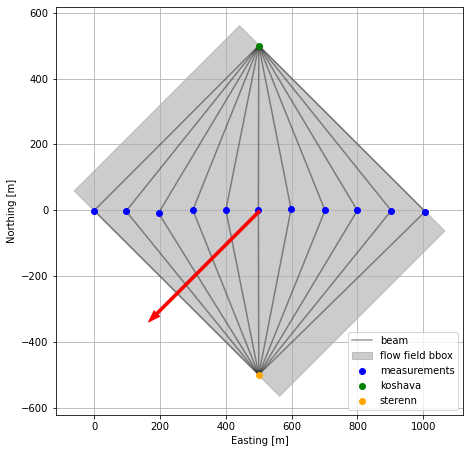

In [17]:
plot_bbox(mc_dual_Doppler)

Contrary to the `uniform` flow field dataset, `turbulent` bounding box is rotated and aligned with the mean wind direction, in this example 45 deg. The above plot shows the size of the window in horizontal plane. In case of the `turbulent` flow field Easting and Northing coordinate are not equal to x and y coordinates of the flow field dataset, since x and y are now relative coordinates which are rotated to be aligned with the wind direction (x) or orthogonal to it (y). End user does not need to deal with any rotation of the coordinates when projecting the wind vector on the line of sight. This is automatically performed by `mocalum`. One thing to notice is that the time step is 2.5 seconds, which in combination with the mean wind speed of 10 m/s corresponds to the x resolution of 25 m. This resolution is a default resolution for x and y for generation of the flow fields in `mocalum`. 

In [18]:
mc_dual_Doppler.data.ffield

<xarray.Dataset>
Dimensions:   (time: 212, x: 30, y: 39, z: 4)
Coordinates:
  * time      (time) float64 0.0 2.5 5.0 7.5 10.0 ... 520.0 522.5 525.0 527.5
  * y         (y) float64 -823.3 -798.3 -773.3 -748.3 ... 76.67 101.7 126.7
  * z         (z) float64 92.78 97.78 102.8 107.8
  * x         (x) float64 -1.755 23.24 48.24 73.24 ... 648.2 673.2 698.2 723.2
    Easting   (x, y) float64 580.9 563.3 545.6 527.9 ... 474.9 457.2 439.5 421.8
    Northing  (x, y) float64 -583.4 -565.7 -548.1 -530.4 ... 565.6 583.3 601.0
    Height    (z) float64 92.78 97.78 102.8 107.8
Data variables:
    u         (time, z, y, x) float64 -6.498 -6.236 -7.555 ... -9.037 -7.707
    v         (time, z, y, x) float64 -8.613 -7.583 -7.22 ... -10.96 -9.139
    w         (time, z, y, x) float64 0.473 -1.244 -0.6739 ... 0.5381 1.442
Attributes:
    generator:  turbulence_box
    title:      Turbulent flow field dataset

`xarray` provides a conviniet way to plot data considering a [non-dimensional coordinates](http://xarray.pydata.org/en/stable/plotting.html#multidimensional-coordinates):
```
xr.dataarray.plot.pcolormesh('non-dim-coord1', 'non-dim-coord2')
```

which in our case are Easting and Northing, and considering we have 4D we will select a specific height and time instance:
```
mc_dual_Doppler.data.ffield.u.isel(z=0, time=0).plot.pcolormesh('Easting', 'Northing')
```
For convenience this plot has been bundeled with the positions of lidars and measurement points in a function `plot_ffield()`:

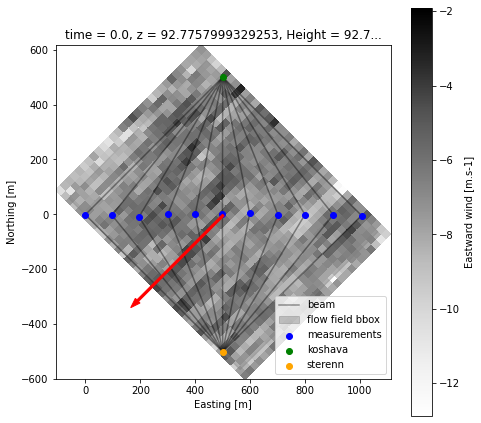

In [19]:
plot_ffield(mc_dual_Doppler)

If we compare the lenght of flow field in time to the actual lenght of the whole measurement scenario (`data.probing[lidar_id]`), we can notice that the measurement scenario takes much longer time than 600 s. Generation of 4D turbulence dataset as long as the total measurement scenario time would require large computational resources. Instead, while projecting the flow field on the los, `mocalum` re-feeds the generated turbulence box once the time step of the probing dataset pass the time lenght of the flow field dataset. 

In [22]:
mc_dual_Doppler.data.ffield.time[-1]

<xarray.DataArray 'time' ()>
array(527.5)
Coordinates:
    time     float64 527.5
Attributes:
    long_name:      Time
    standard_name:  time
    units:          s
    URI:

In [23]:
mc_dual_Doppler.data.probing['koshava'].time[-1]

<xarray.DataArray 'time' ()>
array(19.440686)
Coordinates:
    time     float64 19.44
Attributes:
    long_name:      Time
    standard_name:  time
    units:          s
    URI: